In [79]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [80]:
# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dropout

import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle

In [259]:
tf.config.run_functions_eagerly(True)
tf.compat.v1.enable_eager_execution()

In [81]:
# directory = 'C:/Users/HMILAB/Desktop/Tony/DL_data/12-2/' # where you want to put the zip files and images
# # directory = "./"
# # if not os.path.exists(directory+'captions.zip'):
# #     print("not exists")
# #     annotation_zip = tf.keras.utils.get_file( directory + 'captions.zip',
# #                                               cache_subdir=directory,
# #                                               origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
# #                                               extract = True)
# annotation_file = directory +'annotations/captions_train2014.json'


# # if not os.path.exists(directory + 'train2014.zip'):
# #     image_zip = tf.keras.utils.get_file(directory + 'train2014.zip',
# #                                       cache_subdir=directory,
# #                                       origin = 'http://images.cocodataset.org/zips/train2014.zip',
# #                                       extract = True)
# PATH = directory +'train2014/'



In [82]:
img_path = 'C:/Users/HMILAB/Desktop/Tony/DL_data/12-2/words_captcha/'
annotation_file = 'C:/Users/HMILAB/Desktop/Tony/DL_data/12-2/spec_train_val.txt'

紀錄圖片名稱及對應的label

In [299]:
img_name_vector = []
words = []

with open(annotation_file, 'r') as f:
    lines = f.readlines()

for line in lines:
    tmp = line.split()
    img_name = tmp[0]+'.png'
    word = tmp[1]
    
    img_name_vector.append(img_path+img_name)
    words.append('<start> ' + ' '.join(list(word)) + ' <end>')
    
    

In [142]:
print(words[:20])

['<start> t h u s <end>', '<start> w w w <end>', '<start> t i e d <end>', '<start> i d s <end>', '<start> j a m <end>', '<start> z o o <end>', '<start> a p p l e <end>', '<start> b i g <end>', '<start> l o t <end>', '<start> a b o v e <end>', '<start> o o o <end>', '<start> d a m e <end>', '<start> d a t e s <end>', '<start> m a s s <end>', '<start> k e y s <end>', '<start> l i n e <end>', '<start> t h e m e <end>', '<start> l i n e s <end>', '<start> m l b <end>', '<start> s e r <end>']


In [116]:
img = tf.io.read_file(img_path+'a0.png')
img = tf.image.decode_png(img, channels=3)
print(img.shape)
plt.imshow(img)

(320, 600, 3)


In [147]:
def load_image(image_path, word):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, (50, 100))
    img = img / 255.0
    return img, word

對label做tokenize

In [148]:
def max_len(tensor):
    return max(len(t) for t in tensor)

In [149]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
tokenizer.fit_on_texts(words)
train_seqs = tokenizer.texts_to_sequences(words)

In [150]:
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [151]:
max_length = max_len(cap_vector)

將data分為train及validation

In [300]:
# Use the first 100000 captchas as training examples
num_examples = 100000
num_examples_val = 120000
num_examples_test = 140000

img_name_train = img_name_vector[:num_examples]
cap_train = cap_vector[:num_examples]

img_name_val = img_name_vector[num_examples:num_examples_val]
cap_val = cap_vector[num_examples:num_examples_val]

img_name_test = img_name_vector[num_examples_val:]

設定training parameters

In [153]:
BATCH_SIZE = 64
BUFFER_SIZE = 5000
embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index) + 1
num_steps = len(img_name_train) // BATCH_SIZE

features_shape = 256
attention_features_shape = 18

In [154]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

dataset = dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [155]:
example_input_batch, example_target_batch = next(iter(dataset))
print(example_input_batch.shape, example_target_batch.shape)
image = np.array(example_input_batch[0])
plt.imshow(image)
plt.show()
print(example_target_batch[0])

(64, 50, 100, 3) (64, 7)


tf.Tensor([ 1 17  3 10 14  5  2], shape=(7,), dtype=int32)


In [156]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
        
    def call(self, features, hidden):
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        return context_vector, attention_weights

建立feature extractor，這邊用CNN當作encoder

In [157]:
class CNN_Encoder(tf.keras.Model):
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        
        layers = [
            Conv2D(96, (3, 3), padding='valid', activation='relu', kernel_initializer='he_uniform'),
            BatchNormalization(),
            MaxPool2D((2, 2), padding='valid'),
            
            Conv2D(128, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'),
            BatchNormalization(),
            Conv2D(256, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'),
            MaxPool2D((2, 2), padding='valid'),
            
            Conv2D(384, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'),
            BatchNormalization(),
            MaxPool2D((2, 2), padding='valid'),
            
            Conv2D(384, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'),
            BatchNormalization(),
            MaxPool2D((2, 2), padding='valid'),
            
            Conv2D(256, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'),
            BatchNormalization(),
            Dropout(0.5)
        ]
        
        self.cnn = tf.keras.models.Sequential(layers)
        self.fc = tf.keras.layers.Dense(embedding_dim, activation='relu')
        
    def call(self, x):
        x = self.cnn(x)
        x = tf.reshape(x, (x.shape[0], -1, x.shape[3]))
        x = self.fc(x)
        return x

建立decoder，這邊一個RNN當作decoder。

In [266]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)
        
        self.attention = BahdanauAttention(self.units)
    
    def call(self, x, features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)
        
        
        x = self.embedding(x)
        
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        
        
        output, state = self.gru(x)
        
        x = self.fc1(output)
        x = tf.reshape(x, (-1, x.shape[2]))
        x = self.fc2(x)
        
        
        return x, state, attention_weights
    
    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [267]:
# Initialize encoder and decoder
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

建立optimizer及loss function

In [271]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_mean(loss_)

In [272]:
checkpoint_path = './checkpoints/train'
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=50)

In [273]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [274]:
loss_plot = []

1. 先將image傳入encoder，得到feature
2. 再將feature與hidden state傳入decoder
3. 將decoder回傳的result與true label做比較，計算loss。而decoder回傳的hidden則會傳回到model中

In [277]:
@tf.function
def train_step(images, targets):
    loss = 0
    
    hidden = decoder.reset_state(batch_size=targets.shape[0])
    
    
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * targets.shape[0], 1)
    
    with tf.GradientTape() as tape:
        # features shape == (BATCH_SIZE, 18, embedding_dim)
        features = encoder(images)
        
        for i in range(1, targets.shape[1]):
            
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            
            loss += loss_function(targets[:, i], predictions)
            
            # teacher forcing
            dec_input = tf.expand_dims(targets[:, i], 1)
            
    total_loss = loss / int(targets.shape[1])
    
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    
    gradients = tape.gradient(loss, trainable_variables)
    
    optimizer.apply_gradients(zip(gradients, trainable_variables))
    
    return total_loss

執行training

In [347]:
EPOCHS = 50

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0
    
    for (batch, (imgs, targets)) in tqdm(enumerate(dataset), total=num_steps):
        target_loss = train_step(imgs, targets)
        total_loss += target_loss
            
    loss_plot.append(total_loss/num_steps)
    
    if epoch % 5 == 0:
        ckpt_manager.save()
    
    print('Epoch {} Loss {:.6f}'.format(epoch+1, total_loss/num_steps))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

1563it [01:52, 13.95it/s]                                                                                              


Epoch 1 Loss 0.028687
Time taken for 1 epoch 112.70607471466064 sec



1563it [01:58, 13.18it/s]                                                                                              


Epoch 2 Loss 0.027545
Time taken for 1 epoch 118.56224298477173 sec



1563it [02:01, 12.89it/s]                                                                                              


Epoch 3 Loss 0.031476
Time taken for 1 epoch 121.23819971084595 sec



1563it [02:02, 12.73it/s]                                                                                              


Epoch 4 Loss 0.023649
Time taken for 1 epoch 122.77766251564026 sec



1563it [02:03, 12.65it/s]                                                                                              


Epoch 5 Loss 0.023324
Time taken for 1 epoch 123.54161667823792 sec



1563it [02:04, 12.59it/s]                                                                                              


Epoch 6 Loss 0.023629
Time taken for 1 epoch 124.3515260219574 sec



1563it [02:04, 12.56it/s]                                                                                              


Epoch 7 Loss 0.022936
Time taken for 1 epoch 124.45465350151062 sec



1563it [02:04, 12.57it/s]                                                                                              


Epoch 8 Loss 0.021880
Time taken for 1 epoch 124.35212469100952 sec



1563it [02:04, 12.52it/s]                                                                                              


Epoch 9 Loss 0.020433
Time taken for 1 epoch 124.87781620025635 sec



1563it [02:03, 12.61it/s]                                                                                              


Epoch 10 Loss 0.020473
Time taken for 1 epoch 123.96583795547485 sec



1563it [02:01, 12.87it/s]                                                                                              


Epoch 11 Loss 0.018607
Time taken for 1 epoch 121.68286681175232 sec



1563it [02:00, 12.93it/s]                                                                                              


Epoch 12 Loss 0.019039
Time taken for 1 epoch 120.92221093177795 sec



1563it [02:00, 12.93it/s]                                                                                              


Epoch 13 Loss 0.020171
Time taken for 1 epoch 120.86993455886841 sec



1563it [02:01, 12.89it/s]                                                                                              


Epoch 14 Loss 0.017059
Time taken for 1 epoch 121.24546337127686 sec



1563it [02:03, 12.71it/s]                                                                                              


Epoch 15 Loss 0.018684
Time taken for 1 epoch 123.03479719161987 sec



1563it [02:02, 12.78it/s]                                                                                              


Epoch 16 Loss 0.015178
Time taken for 1 epoch 122.4879777431488 sec



1563it [02:01, 12.82it/s]                                                                                              


Epoch 17 Loss 0.018295
Time taken for 1 epoch 121.94017362594604 sec



1563it [02:02, 12.79it/s]                                                                                              


Epoch 18 Loss 0.015738
Time taken for 1 epoch 122.18240141868591 sec



1563it [02:03, 12.70it/s]                                                                                              


Epoch 19 Loss 0.015279
Time taken for 1 epoch 123.08601593971252 sec



1563it [02:02, 12.73it/s]                                                                                              


Epoch 20 Loss 0.014609
Time taken for 1 epoch 122.81368088722229 sec



1563it [02:02, 12.72it/s]                                                                                              


Epoch 21 Loss 0.015143
Time taken for 1 epoch 123.10983347892761 sec



1563it [02:02, 12.72it/s]                                                                                              


Epoch 22 Loss 0.014505
Time taken for 1 epoch 122.84000849723816 sec



1563it [02:02, 12.76it/s]                                                                                              


Epoch 23 Loss 0.014417
Time taken for 1 epoch 122.52587223052979 sec



1563it [02:03, 12.68it/s]                                                                                              


Epoch 24 Loss 0.014210
Time taken for 1 epoch 123.25545811653137 sec



1563it [02:03, 12.66it/s]                                                                                              


Epoch 25 Loss 0.013999
Time taken for 1 epoch 123.48379349708557 sec



  0%|                                                                                         | 0/1562 [00:01<?, ?it/s]


KeyboardInterrupt: 

In [348]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [349]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))
    
    hidden = decoder.reset_state(batch_size=1)
    
    features = encoder(image)
    
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []
    
    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        
        attention_plot[i] = tf.reshape(attention_weights, (-1,)).numpy()
        
        predicted_id = tf.argmax(predictions[0]).numpy()
        
        
        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot
        
        result.append(tokenizer.index_word[predicted_id])
        
        dec_input = tf.expand_dims([predicted_id], 0)
    
    attention_plot = attention_plot[:len(result), :]

    return result, attention_plot

In [353]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (3, 6))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: <start>toll<end>
Prediction Caption: told


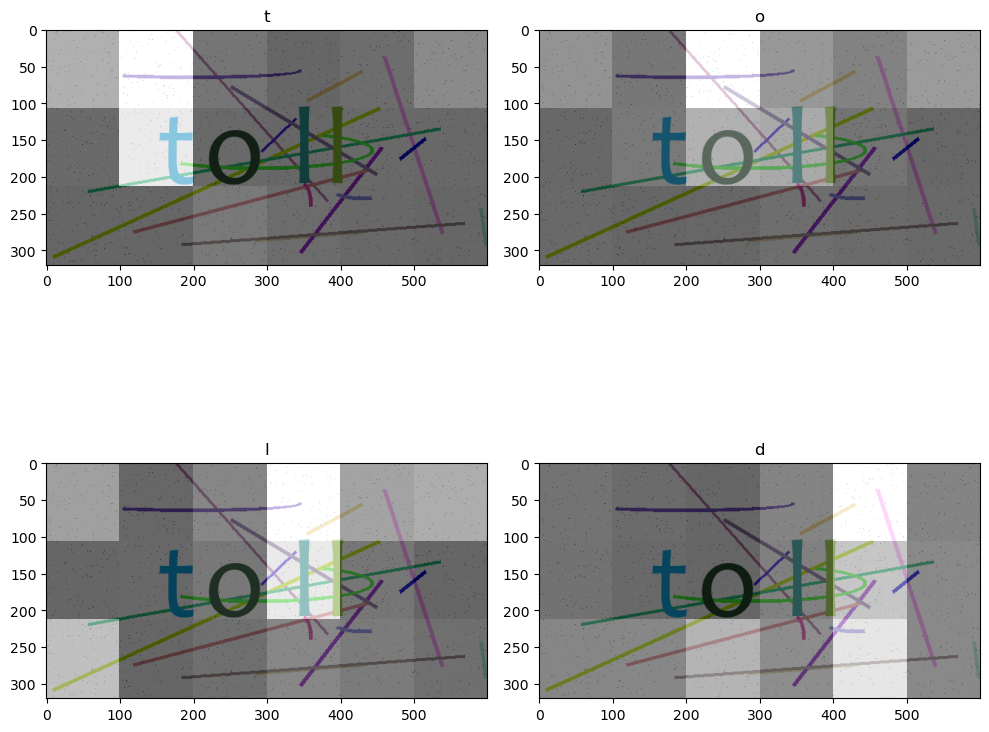

In [354]:
rid = np.random.randint(0, len(img_name_val))

image, caption = load_image(img_name_val[rid], cap_val[rid])
image = tf.expand_dims(image, 0)
real_caption = ''.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)
print ('Real Caption:', real_caption)
print ('Prediction Caption:', ''.join(result))
# Image.open(img_name_val[rid])
plot_attention(img_name_val[rid], result, attention_plot)

In [355]:
dataset_val = tf.data.Dataset.from_tensor_slices((img_name_val, cap_val))
dataset_val = dataset_val.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [356]:
predictions = []
targets = []

for (batch, (img, target)) in tqdm(enumerate(dataset_val)):
    img = tf.expand_dims(img, 0)
    result, attention_plot = evaluate(img)############
    
    predictions.append(''.join(result))
    
    real_caption = ''.join([tokenizer.index_word[i] for i in cap_val[batch] if i not in [0, 1, 2]])
    targets.append(real_caption)

20000it [06:42, 49.63it/s]


In [376]:
print('Validation accuracy:', np.mean(np.array(predictions) == np.array(targets)))

Validation accuracy: 0.90112


# Make prediction

In [358]:
def load_test_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, (50, 100))
    img = img / 255.0
    return img

In [359]:
img_name_test = []
name=[]
img_path = 'C:/Users/HMILAB/Desktop/Tony/DL_data/12-2/test_image/'
for img_name in tqdm(os.listdir(img_path)):
    img_path_name = img_path + img_name
    name.append(img_name.split('.')[0])
    if img_path_name not in img_name_vector and img_path_name != annotation_file:
        img_name_test.append(img_path_name)

100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:16<00:00, 1194.87it/s]


In [360]:
dataset_test = tf.data.Dataset.from_tensor_slices(img_name_test)
dataset_test = dataset_test.map(load_test_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [361]:
predictions = []

for batch, img in tqdm(enumerate(dataset_test)):
    img = tf.expand_dims(img, 0)
    result, attention_plot = evaluate(img)
    predictions.append(''.join(result))
    


20000it [06:49, 48.78it/s]


In [365]:
print(name[:20])

['a120000', 'a120001', 'a120002', 'a120003', 'a120004', 'a120005', 'a120006', 'a120007', 'a120008', 'a120009', 'a120010', 'a120011', 'a120012', 'a120013', 'a120014', 'a120015', 'a120016', 'a120017', 'a120018', 'a120019']


In [369]:
print(len(predictions))

20000


fail


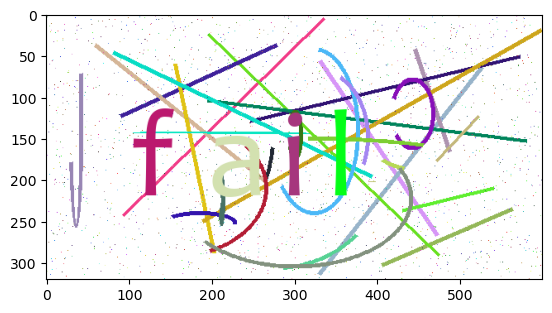

sald


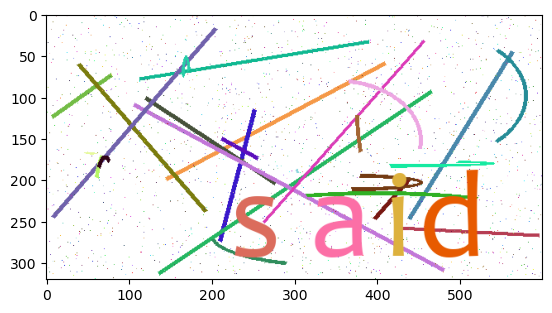

stars


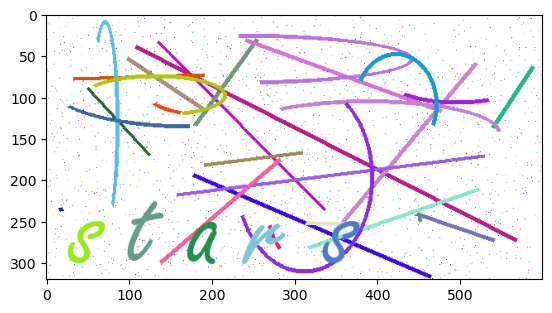

issn


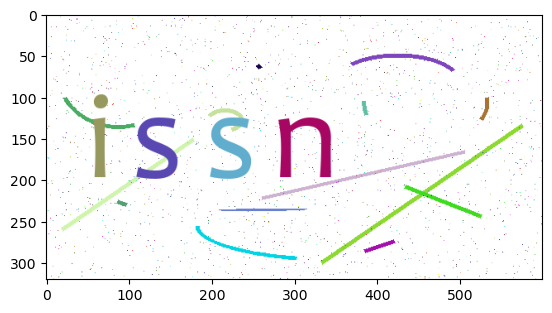

yoga


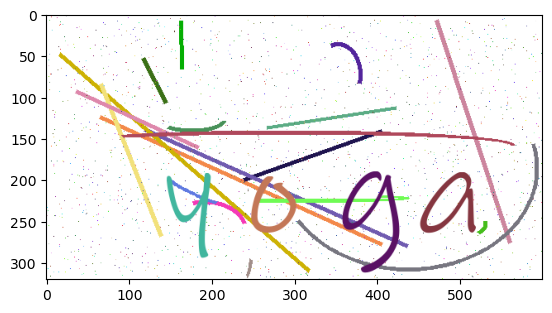

wrote


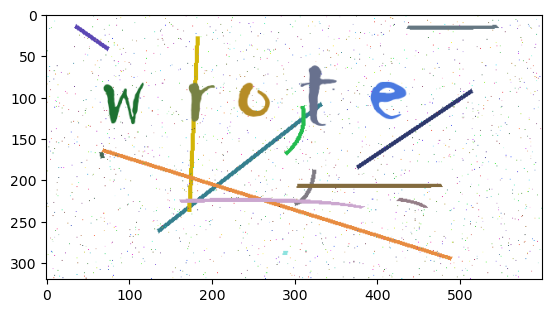

mail


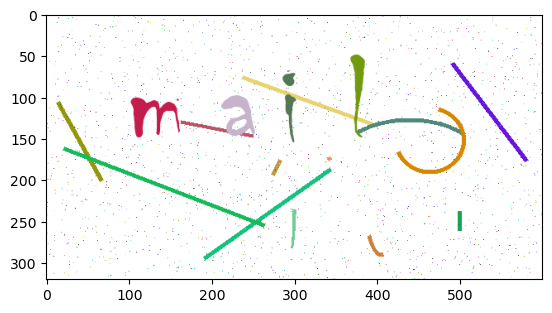

jews


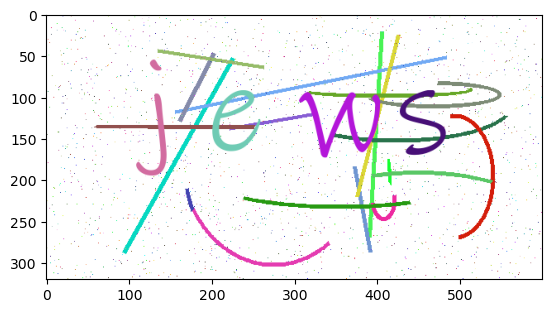

nil


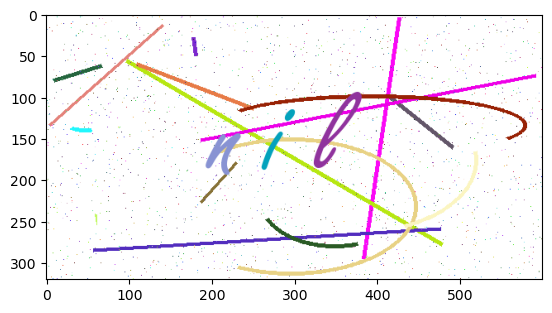

risk


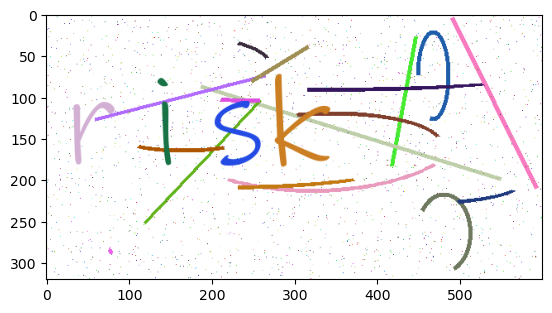

sip


reg


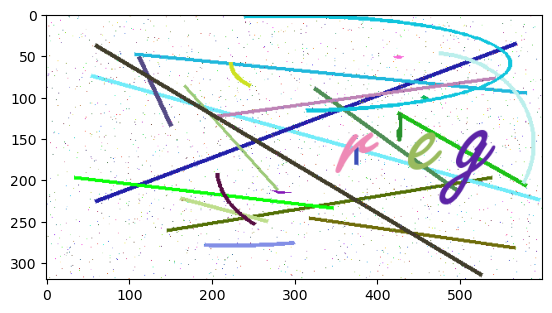

cant


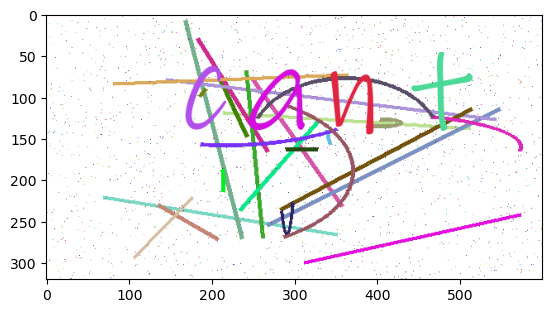

pod


toe


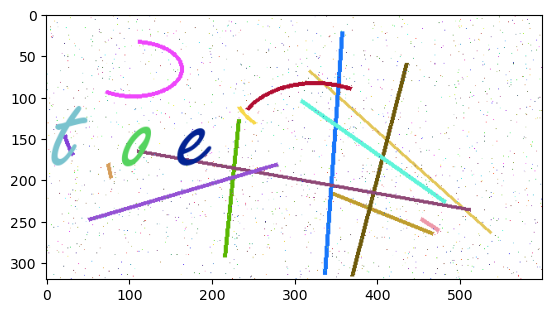

knit


dumb


armed


ange


early


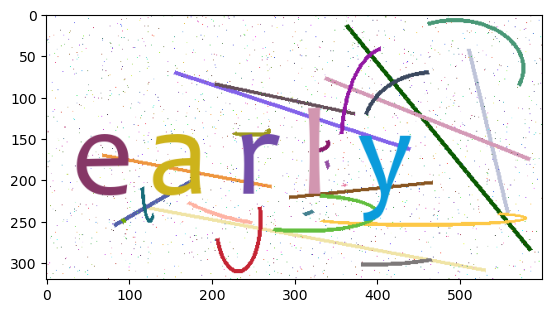

top


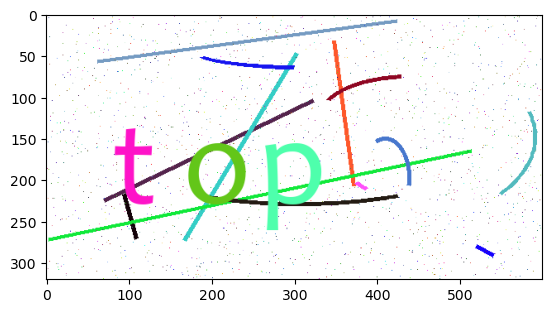

vhs


store


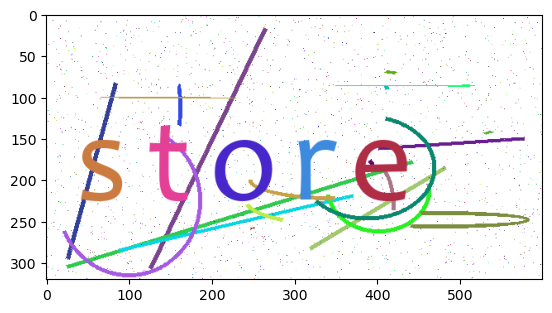

dogs


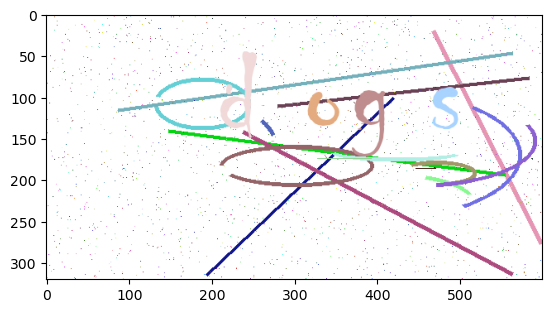

scott


jock


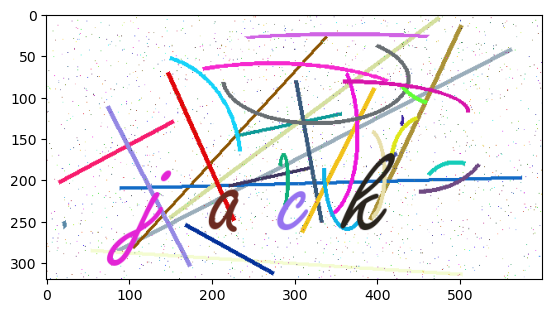

seven


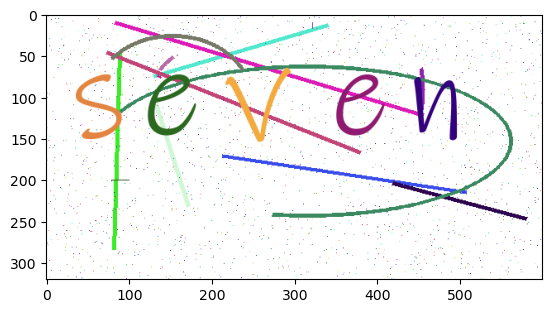

seve


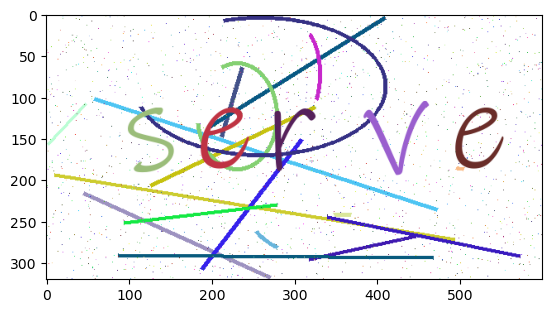

wrea


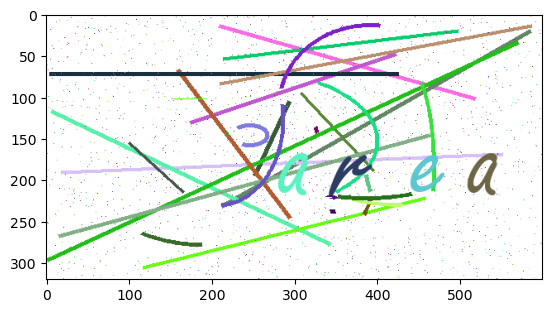

lee


xml


east


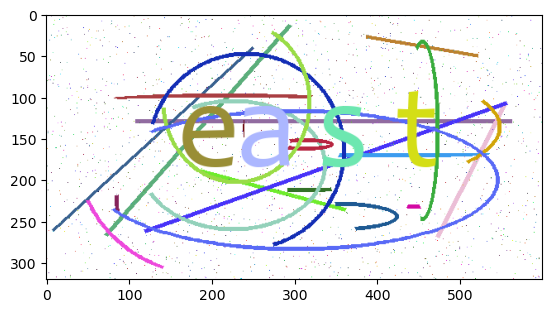

pain


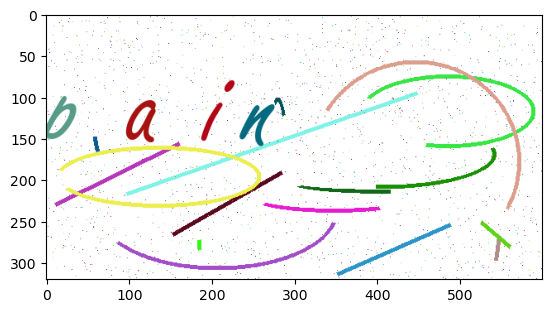

fist


got


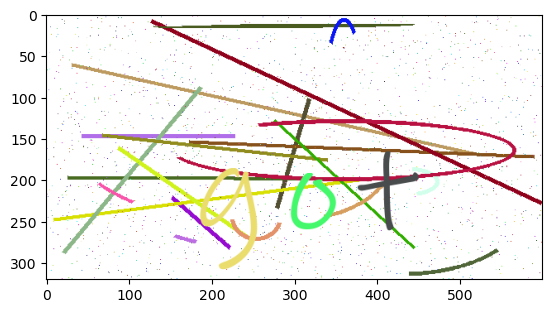

cnn


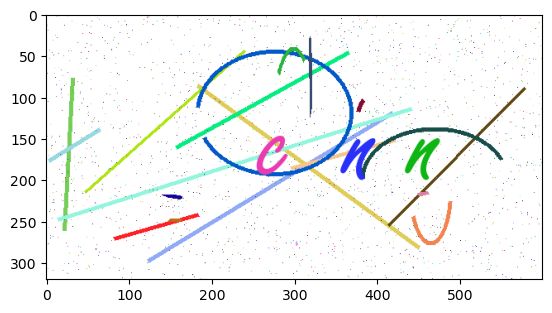

src


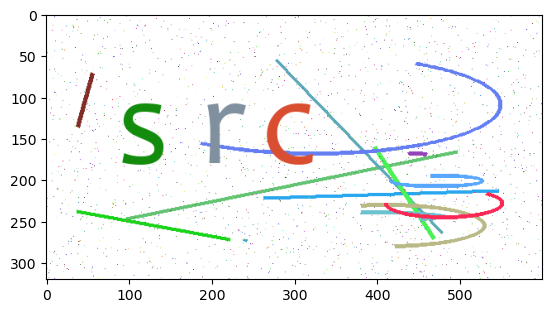

among


cite


using


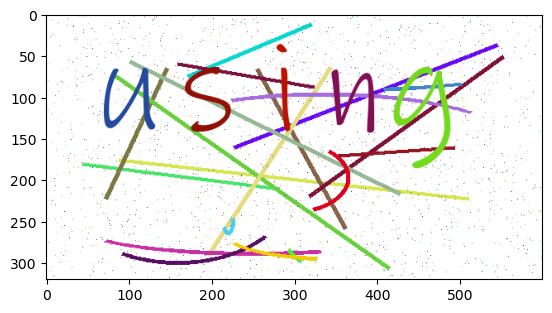

notes


moore


boom


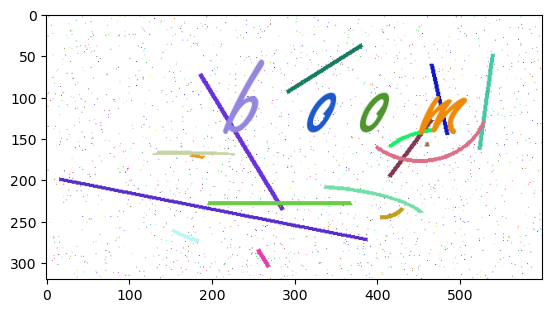

cub


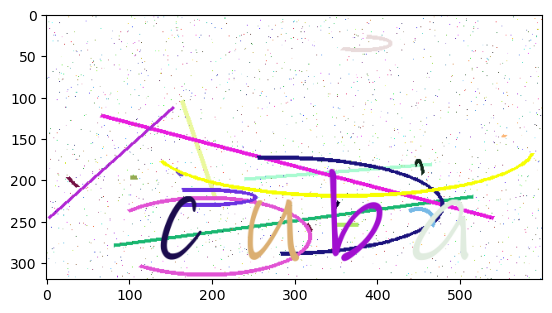

ken


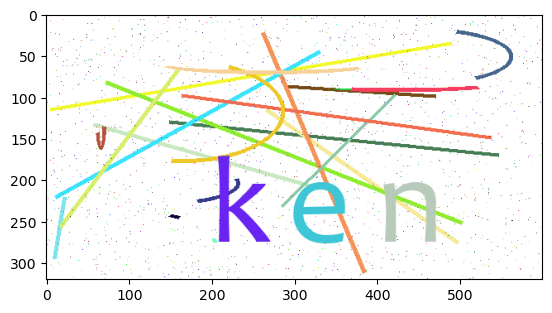

all


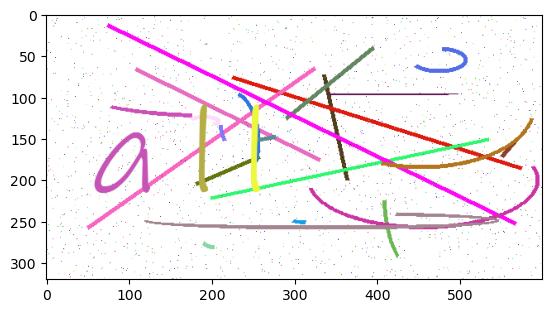

sand


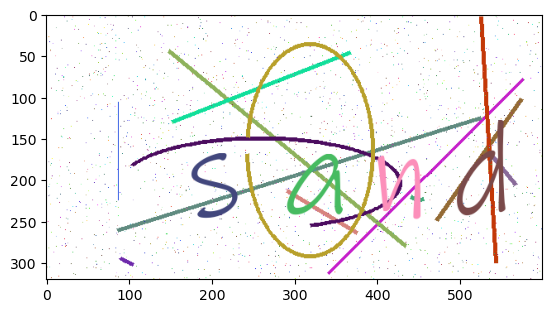

hour


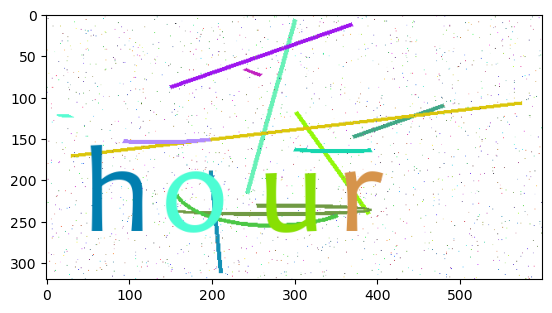

keen


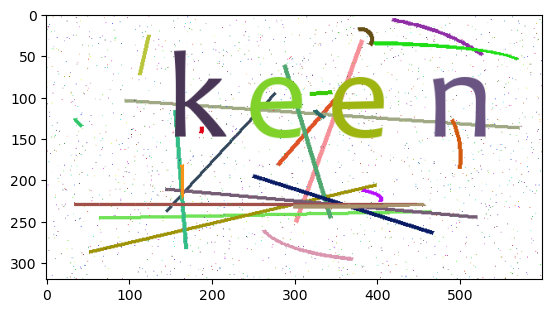

foll


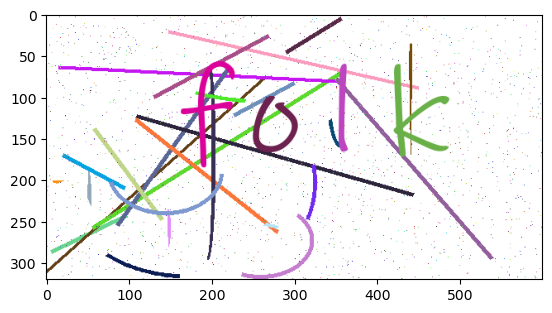

In [368]:
i=0
for img in img_name_test[:50]:
    print(predictions[i])
    i+=1
    plt.imshow(Image.open(img))
    plt.show()

In [374]:
output_file = open('Lab12-2_108062313.txt', 'w')

In [375]:
for i in range(len(predictions)):
    output_file.write(name[i])
    output_file.write(" ")
    output_file.write(predictions[i])
    output_file.write("\n")
output_file.close()